In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_full = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_full = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

classes = [0,1,2,3,4]

def filter_classes(dataset):
    idx = [i for i, (_, y) in enumerate(dataset) if y in classes]
    return torch.utils.data.Subset(dataset, idx)

train_full = filter_classes(train_full)
test_set  = filter_classes(test_full)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.92MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.3MB/s]


In [4]:
train_size = int(0.8 * len(train_full))
test_size = len(train_full) - train_size

train_set, val_set = torch.utils.data.random_split(
    train_full, [train_size, test_size]
)


In [5]:
N = len(train_set)

train_loader_sgd = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True
)

train_loader_batch = torch.utils.data.DataLoader(
    train_set, batch_size=N, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=256, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=256, shuffle=False
)


In [6]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 5)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
criterion = nn.CrossEntropyLoss()

In [8]:
def train_model(model, optimizer, loader):
    model.train()
    losses = []
    prev_loss = float("inf")
    epoch = 0

    while True:
        total_loss = 0.0

        for x, y in loader:
            x = x.view(x.size(0), -1).to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)

        if abs(prev_loss - avg_loss) < 1e-4:
            print(f"Converged at epoch {epoch}")
            break

        prev_loss = avg_loss
        epoch += 1

    return losses


In [9]:
def accuracy(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.view(x.size(0), -1).to(device)
            y = y.to(device)

            preds = torch.argmax(model(x), dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


In [10]:
optimizers = {
    "SGD": lambda m: optim.SGD(m.parameters(), lr=0.001),

    "BatchGD": lambda m: optim.SGD(m.parameters(), lr=0.001),

    "Momentum": lambda m: optim.SGD(
        m.parameters(), lr=0.001, momentum=0.9
    ),

    "NAG": lambda m: optim.SGD(
        m.parameters(), lr=0.001, momentum=0.9, nesterov=True
    ),

    "RMSProp": lambda m: optim.RMSprop(
        m.parameters(), lr=0.001, alpha=0.99, eps=1e-8
    ),

    "Adam": lambda m: optim.Adam(
        m.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-8
    )
}


In [11]:
results = {}

base_model = FCNN().to(device)
initial_state = base_model.state_dict()

for name, opt_fn in optimizers.items():
    print("\n==============================")
    print(f"Training with {name}")
    print("==============================")

    model = FCNN().to(device)
    model.load_state_dict(initial_state)

    optimizer = opt_fn(model)

    loader = train_loader_batch if name == "BatchGD" else train_loader_sgd

    loss_curve = train_model(model, optimizer, loader)

    train_acc = accuracy(model, train_loader_sgd)
    val_acc = accuracy(model, val_loader)
    test_acc = accuracy(model, test_loader)

    results[name] = {
        "epochs": len(loss_curve),
        "loss": loss_curve,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "test_acc": test_acc
    }



Training with SGD
Converged at epoch 14

Training with BatchGD
Converged at epoch 1

Training with Momentum
Converged at epoch 20

Training with NAG
Converged at epoch 15

Training with RMSProp
Converged at epoch 99

Training with Adam
Converged at epoch 153


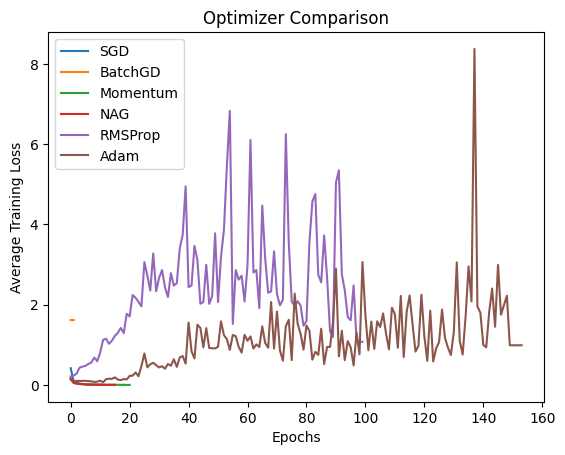

In [12]:
for name in results:
    plt.plot(results[name]["loss"], label=name)

plt.xlabel("Epochs")
plt.ylabel("Average Training Loss")
plt.title("Optimizer Comparison")
plt.legend()
plt.show()


In [13]:
for name, res in results.items():
    print(
        name,
        "| Epochs:", res["epochs"],
        "| Train Acc:", round(res["train_acc"],4),
        "| Val Acc:", round(res["val_acc"],4),
        "| Test Acc:", round(res["test_acc"],4)
    )


SGD | Epochs: 15 | Train Acc: 1.0 | Val Acc: 0.9895 | Test Acc: 0.993
BatchGD | Epochs: 2 | Train Acc: 0.2004 | Val Acc: 0.2002 | Test Acc: 0.1965
Momentum | Epochs: 21 | Train Acc: 1.0 | Val Acc: 0.9923 | Test Acc: 0.9949
NAG | Epochs: 16 | Train Acc: 1.0 | Val Acc: 0.9933 | Test Acc: 0.9944
RMSProp | Epochs: 100 | Train Acc: 0.4978 | Val Acc: 0.4899 | Test Acc: 0.5065
Adam | Epochs: 154 | Train Acc: 0.5185 | Val Acc: 0.508 | Test Acc: 0.5207


In [14]:
best = max(results, key=lambda k: results[k]["val_acc"])
print("Best Optimizer:", best)


Best Optimizer: NAG
